   ## CM de Actividad Evocada
   Aquí cargaremos las funciones que permiten tener el CM de Pozos y Fuentes a partir de los datos analizados en el Notebook aledaño. 

In [1]:
using JLD
using PyPlot
matplotlib[:rcParams][:"svg.image_noscale"]=false

false

In [2]:
CSD=load("CSDEvocada.jld", "CSD")
CSDPlanchado=load("CSDEvocada.jld", "CSDPlanchada")
CSDPromedio=CSD["Trancazo_1"]+CSD["Trancazo_2"]+CSD["Trancazo_3"]
CSDPlanchadoPromedio=CSDPlanchado["Trancazo_1"]+CSDPlanchado["Trancazo_2"]+CSDPlanchado["Trancazo_3"];

In [3]:
xizq=22
xder=48
ybajo=4
yalto=30
tmax=size(CSDPromedio)[3]
tiemposinteresantes=(63,70,77,84,91,98)

(63,70,77,84,91,98)

In [4]:
function vecindad8(punto::Array)
    j=punto[1]
    k=punto[2]
    result=Set{Array{Int64,1}}()
    push!(result, [j-1,k-1])
    push!(result, [j-1,k])
    push!(result, [j-1,k+1])
    push!(result, [j,k-1])
    push!(result, [j,k+1])
    push!(result, [j+1,k-1])
    push!(result, [j+1,k])
    push!(result, [j+1,k+1])
    return result
end

vecindad8 (generic function with 1 method)

In [5]:
function ComponenteLista(Datos::Array, epsilon=1.0, tau=300)
    #Solo obten componentes de un frame y escribelos.  
    #iniciar variables vacias
    ActividadNegativa=Array{Int16}[]
    ActividadPositiva=Array{Int16}[]
    (mu,nu,lu)=size(Datos)
    SpikeCountPositivo=zeros(mu,nu)
    SpikeCountNegativo=zeros(mu,nu)
    #Todos
    for j=1:mu, k=1:nu
            if(Datos[j,k,tau]<-epsilon)     
            push!(ActividadNegativa, [j, k])
            SpikeCountNegativo[j,k]+=1
                elseif(Datos[j,k,tau]>epsilon)
            push!(ActividadPositiva, [j, k])
            SpikeCountPositivo[j,k]+=1
        end             
    end

    #Simple pass method
    listaneg=copy(ActividadNegativa)
    listapos=copy(ActividadPositiva)
    componentesneg=Set{Any}()
    componentespos=Set{Any}()
    
    
    #Primero lo negativo (pozos)
    while(length(listaneg)!=0)
        x=pop!(listaneg) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<4000)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listaneg)
             #   
                        deleteat!(listaneg, indexin(Any[v], listaneg))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentesneg, componentecurlab)
    end


    etiqueta=0
    outfile = open("ComponenteCollector/CompNeg-$tau.dat", "w")
    
    for p in componentesneg
        etiqueta+=1
    
        for q in p
            j=q[2]
            k=q[1]
            masalocal=Datos[j,k,tau]
            write(outfile,join((j,k,masalocal,etiqueta), "\t"),"\n")
        end
        write(outfile, "\n")
    end
    close(outfile)    
    

    ##### Ahora lo posittivo (fuentes)
    while(length(listapos)!=0)
        x=pop!(listapos) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<4000)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listapos)
             #   
                        deleteat!(listapos, indexin(Any[v], listapos))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentespos, componentecurlab)
    end


    etiqueta=0
    outfile = open("ComponenteCollector/CompPos-$tau.dat", "w")
    
    for p in componentespos
        etiqueta+=1
    
        for q in p
            j=q[2]
            k=q[1]
            masalocal=Datos[j,k,tau]
            write(outfile,join((j,k,masalocal,etiqueta), "\t"),"\n")
        end
        write(outfile, "\n")
    end
    close(outfile)    
    
end

ComponenteLista (generic function with 3 methods)

In [6]:
function ObtenComponentesYEscribe(Datos::Array, tini=1, tfini=tmax, epsilon=1.0)
    #CSD ahora no tiene orillas. Asi que toca adaptarse.
    (alto,ancho,lu)=size(Datos)
    #la cantidad minima de pixeles que tiene que tener un componente para
    #que lo tomemeos en cuenta
    tamano=3
    
 for t=tini:tfini
    #iniciar variables vacias
    ActividadNegativa=Array{Int16}[]
    ActividadPositiva=Array{Int16}[]
        SpikeCountPositivo=zeros(alto,ancho)
        SpikeCountNegativo=zeros(alto,ancho)
    #Todos
        for j=1:alto, k=1:ancho
            if(Datos[j,k,t]<-epsilon)     
            push!(ActividadNegativa, [j, k])
            SpikeCountNegativo[j,k]+=1
                elseif(Datos[j,k,t]>epsilon)
            push!(ActividadPositiva, [j, k])
            SpikeCountPositivo[j,k]+=1
        end             
    end

    #Simple pass method
    listaneg=copy(ActividadNegativa)
    listapos=copy(ActividadPositiva)
    componentesneg=Set{Any}()
    componentespos=Set{Any}()
    #Primero lo negativo (pozos)
    while(length(listaneg)!=0)
        x=pop!(listaneg) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<1000)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listaneg)
             #   
                        deleteat!(listaneg, indexin(Any[v], listaneg))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentesneg, componentecurlab)
    end


    centrosdemasaneg=[[0 0 0];]
    for p in componentesneg
        mu=length(p)
            
        if mu>tamano
            masa=0.00
            x=0.00
            y=0.00
            for q in p
                j=q[1]
                k=q[2]
                masalocal=Datos[j,k,t]
                masa+=masalocal
                x+=k*masalocal
                y+=j*masalocal
            end
            x/=masa
            y/=masa
            A=[x y masa]
            centrosdemasaneg=vcat(centrosdemasaneg, A)
        end
    end
        
    centrosdemasaneg=centrosdemasaneg[2:end,:]
        zacatlan="CenterOfMassCollector/CMPozos-$t.dat"
    writedlm(zacatlan, centrosdemasaneg)
        
        
    ##### Ahora lo posittivo (fuentes)
    while(length(listapos)!=0)
        x=pop!(listapos) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<1000)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listapos)
             #   
                        deleteat!(listapos, indexin(Any[v], listapos))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentespos, componentecurlab)
    end


    centrosdemasapos=[[0 0 0];]
    for p in componentespos
            mu=length(p)
        if mu>tamano
            masa=0.00
            x=0.00
            y=0.00
            for q in p
                j=q[1]
                k=q[2]
                masalocal=Datos[j,k,t]
                masa+=masalocal
                x+=k*masalocal
                y+=j*masalocal
            end
            x/=masa
            y/=masa
            A=[x y masa]
            centrosdemasapos=vcat(centrosdemasapos, A)
        end
    end
        
    centrosdemasapos=centrosdemasapos[2:end,:]
    
        
    zacatlan="CenterOfMassCollector/CMFuentes-$t.dat"
    writedlm(zacatlan, centrosdemasapos)
end
    return 0
end

ObtenComponentesYEscribe (generic function with 4 methods)

In [7]:
function leeunmegaarray(NomineGeneralis::AbstractString, desde=35, hasta=501)
    LeMegaArray=Array[]
    for t=desde:hasta
      #  println("$NomineGeneralis-$t.dat")
        CMx=readdlm("$NomineGeneralis-$t.dat")
        push!(LeMegaArray, CMx)
    end
    return LeMegaArray
end

leeunmegaarray (generic function with 3 methods)

In [8]:
function dist2D(x::Array,y::Array)
    result=sqrt((x[1]-y[1])^2+(x[2]-y[2])^2)
    return result
end

dist2D (generic function with 1 method)

In [23]:
function encuentraTrayectorias(Datos::Array, mincadena=20)

toleradist=6.0*sqrt(2)
tau=1
t=1
j=1
Catenario=Set{Array{Any}}()
Cadena=[0 0 0 0]
    CopiaMegaArray=deepcopy(Datos);
    NumFrames=length(Datos)
FakeNumFrames=NumFrames



while t <= FakeNumFrames-1 
    
    tau=t
    
    @label arrrrh
  
    jmax,nada= size(CopiaMegaArray[tau])
    
    while j <=jmax && tau<FakeNumFrames
        
            if abs(CopiaMegaArray[tau][j,3]) > 0.05
                       
            Eslabon=[copy(CopiaMegaArray[tau][j,:]) tau]
            Cadena=vcat(Cadena, Eslabon)
         #   println("Papa t: ", t, "  tau: ", tau, " y  j: ",j )
            mindist=2
            kasterisco=1
            kmax, nada= size(CopiaMegaArray[tau+1])
            huboalgo=false
          
        #    kmax=5
            
            for k=1:kmax
                
                EslabonTentativo=CopiaMegaArray[tau+1][k,:]
            #    println(EslabonTentativo)
                    if abs(EslabonTentativo[3])>0.05
                    dist=dist2D(Eslabon,EslabonTentativo)                  
                    if dist<mindist
                        mindist=dist
                        kasterisco=k
                        
                       # println(kasterisco, "=k*", k, "=k")
                        huboalgo=true
                    end
                end
            
            end    
            
            if huboalgo && mindist<toleradist
                #quitamos el anterior
                CopiaMegaArray[tau][j,3]=0.0000 
               # println(mindist," ", t, " ", tau+1 ," ", kasterisco )
                
                if tau+1<FakeNumFrames
                    tau+=1
                    j=kasterisco
      #              println("Pepe t: ", t, "  tau: ", tau, " y  j: ",j )
                    @goto arrrrh
                
                else
                    
                    Eslabon=[copy(CopiaMegaArray[tau+1][kasterisco,:]) tau+1]
                    Cadena=vcat(Cadena, Eslabon)
      #              println("Pipi t: ", t, "  t: ", t, " y  j: ",j )
                    j+=1
                    tau=t
                    
                    if size(Cadena)[1]>mincadena
                        push!(Catenario, Cadena[2:end,:])
                    end
                    
                    Cadena=[0 0 0 0]
                    @goto arrrrh
                end
                                
            else
                
                if size(Cadena)[1]>mincadena
                    push!(Catenario, Cadena[2:end,:])
                end
                Cadena=[0 0 0 0]
                j+=1
                tau=t
                @goto arrrrh
            end
                       
        end #cierra sobre el if de  la masa 
                
        j+=1                    
        tau=t
    
    end
    @label urrr
      
    j=1
    t+=1
    tau=t
    Cadena=[0 0 0 0]
end 
    
    return Catenario
end

encuentraTrayectorias (generic function with 2 methods)

In [10]:
SubCSD=getindex(CSDPromedio, ybajo:yalto,xizq:xder,1:tmax);

In [11]:
ComponenteLista(SubCSD, 15, 91)

In [12]:
ObtenComponentesYEscribe(SubCSD, 40,200,15)

0

In [13]:
MegaArrayPositivo=Array[]
MegaArrayNegativo=Array[]
MegaArrayPositivo=leeunmegaarray("CenterOfMassCollector/CMFuentes",40,180);
MegaArrayNegativo=leeunmegaarray("CenterOfMassCollector/CMPozos",40,180);

In [24]:
#Recuerda el segundo argumento es la longitud mínima de la cadena
CatenarioPositivo=encuentraTrayectorias(MegaArrayPositivo, 3);
CatenarioNegativo=encuentraTrayectorias(MegaArrayNegativo,3);

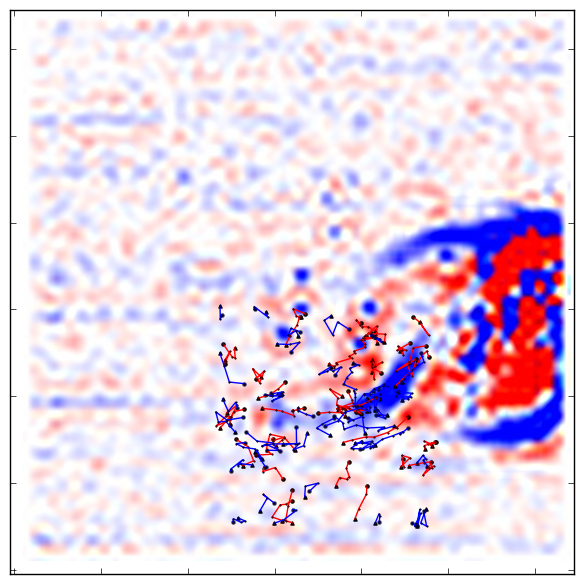

In [28]:
ion()

ImagenCSD=CSDPromedio[:,:,64];

figure(figsize=(6,6))
#axis("equal")
tick_params(labelbottom="off", labelleft="off")
xlim(-0.50,64+0.5)
ylim(-0.5,64+0.5)
bolitasrojas=0
bolitasazules=0
minlargo=3
marcagor=5
muevemin=0.5
limcsd=180
tight_layout()

guacafondo=imshow(ImagenCSD, cmap="bwr", interpolation="sinc", 
origin="lower", vmin=-limcsd, vmax=limcsd, extent=[1,64,1,64])

for p in CatenarioPositivo
    gordura=abs(map(Float32,p[:,3]))
    desviax=std(map(Float32,p[:,1]))
    desviay=std(map(Float32,p[:,2]))
    longus,falsus=size(p)
    if mean(gordura)> marcagor && (desviax>muevemin || desviay>muevemin) && longus> minlargo 
        #Si son chiquitos no nos interesan.
        xxpos=p[:,1]+xizq
        yypos=p[:,2]+ybajo    
        tiempos=p[:,4]/7022    
        plot(xxpos, yypos, marker="o", markersize=1, color="r")
        #bolitasrojas=scatter(xxpos,yypos, s=gordura, 
        #edgecolors="none", color="r" )
        inicios=scatter(xxpos[1],yypos[1], s=marcagor, edgecolors="black", 
        linewidth=1,
        facecolor="red", marker="o" )
        finales=scatter(xxpos[end],yypos[end], s=marcagor, edgecolors="black", 
        linewidth=1,facecolor="red", marker="^", label="Final" )
      #  annotate(round(tiempos[1]*1000,1),  (xxpos[1], yypos[1]), fontsize=7, color="black")
       # annotate(round(tiempos[end]*1000,1), (xxpos[end], yypos[end]), fontsize=7, color="green")

    end
end




for p in CatenarioNegativo
    gordura=abs(map(Float32,p[:,3]))
    desviax=std(map(Float32,p[:,1]))
    desviay=std(map(Float32, p[:,2]))
    longus,falsus=size(p)
    if mean(gordura)>marcagor && (desviax>muevemin || desviay > muevemin) &&longus> minlargo
        #Si son chiquitos no nos interesan.
        xxpos=p[:,1]+xizq
        yypos=p[:,2]+ybajo    
        tiempos=p[:,4]/7022    
        plot(xxpos, yypos, marker="o", markersize=1, color="b")
        #bolitasazules=scatter(xxpos,yypos, s=gordura,
        #edgecolors="none", color="b")
        inicios=scatter(xxpos[1],yypos[1], s=marcagor, edgecolors="black", 
        linewidth=1,
        facecolor="blue", alpha=0.7, marker="o", label="Final" )
        finales=scatter(xxpos[end],yypos[end], s=marcagor, edgecolors="black", 
        linewidth=1,
        facecolor="blue", marker="^", label="Final" )
      #  annotate(round(tiempos[1],4),  (xxpos[1], yypos[1]), fontsize=7, color="black")
      #  annotate(round(tiempos[end],4), (xxpos[end], yypos[end]), fontsize=7, color="green")

    end
end


In [21]:
save("CatenariosEvocados-Promedio-3.jld", "CatenarioNegativo", CatenarioNegativo, "CatenarioPositivo", CatenarioPositivo)

In [30]:
for t in tiemposinteresantes
    ComponenteLista(CSDPromedio, 2, t)
end